In [1]:
%config Completer.use_jedi = False

import pickle

import numpy as np
import pandas as pd

pd.set_option('mode.chained_assignment', None)

import util.explore as explore_util

import statsmodels.api as sm

from econml.dml import NonParamDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt

Steps:

1. Code for sector
2. Load in MDG panel
3. Construct non-lag project - MDG DF for sector, with vars as in specifications
4. Extract further project features: size relative to GDP, ratings, basic features of PDO and descriptions, etc.
5. Do some crawls over lag periods, features and feature combinations
6. Get ready for some graph work


## Load in all projects from WB project panel, and merge with MDG panel data

In [3]:
# all_projects = pd.read_csv('../data/clean_wb_proj_all.csv', index_col=0)

In [4]:
reassemble_proj_country_df = False

df = pd.read_json("../data/aggregated_proj.json", orient="index")
country_panel = pd.read_csv('../data/countrypanel.csv')

if reassemble_proj_country_df:
    df['boardapprovaldate'] = pd.to_datetime(df['boardapprovaldate'])
    df['closingdate'] = pd.to_datetime(df['closingdate'])
    df['closingyear'] = df.closingdate.dt.year

    # will need to redo some manual work here

    # cname_counts = df.groupby(['countryname'], as_index=False).agg(project_count=('id', 'count'))
    # cname_counts['project_country'] = cname_counts['countryname']
    # panel_counts = country_panel.groupby(['countryname'], as_index=False).agg(year_count=('year', 'count'))

    # country_matcher = cname_counts.merge(panel_counts, how='left')
    # country_matcher.to_csv('../data/tmp/project_countries.csv', index=False)
    # panel_counts.to_csv('../data/tmp/panel_countries.csv', index=False)

    new_country_df = pd.read_csv('../data/tmp/project_countries.csv')

    ndf = df.merge(new_country_df[['project_country', 'panel_country']], 
                   left_on='countryname', right_on='project_country', how='left')

    ndf = ndf.drop(columns=['countryname'])
    ndf = ndf[ndf.panel_country.notna()]
    
    save_transformed_df = False
    if save_transformed_df:
        ndf.to_csv('../data/transformed_data/projects_with_ccodes.csv')

else:
    ndf = pd.read_csv('../data/transformed_data/projects_with_ccodes.csv', index_col=0, low_memory=False)
    ndf['boardapprovaldate'] = pd.to_datetime(ndf['boardapprovaldate'])
    ndf['closingdate'] = pd.to_datetime(ndf['closingdate'])

In [5]:
ipf_data = pd.read_csv('../data/prior_proj_paper/ipf_paper_data.csv')
print(ndf.id.isin(ipf_data.projid).sum())

ipf_feature_cols = [
    'origcommamt',
    'cpia_approval',
    'region',
    'gp',
    'fundingsource',
    'fcsatappfy',
    'uppermiddle_income_appfy',
    'origprojlength',
    'prepttl_exp',
    'prepttl_quality_va'    
]

ndf = ndf.merge(ipf_data[['projid'] + ipf_feature_cols], left_on='id', right_on='projid', how='left')

4271

What is:
* mjthemecode

Also, these have XML / extractable information:
* indicatormappingdata

In [8]:
with open("../data/transformed_data/title_pdo_embeds_reduced.pkl", "rb") as fin:
    embeddings = pickle.load(fin)

em_ext = dict(
    project_id=embeddings["project_ids"],
    embed_x=embeddings["tsne"][:, 0],
    embed_y=embeddings["tsne"][:, 1]
)
embed_df = pd.DataFrame(em_ext)

In [9]:
ndf = ndf.merge(embed_df, left_on="id", right_on="project_id", how="left")

In [10]:
dli_df = pd.read_csv('../data/transformed_data/clean_dli_pdo_tsne_sector.csv')
dli_df = dli_df.rename(columns={ 'tsne_x': 'dli_x', 'tsne_y': 'dli_y' })

In [11]:
dli_df.head()

,id,parent_sector_name,dli_x,dli_y,pdo_tsne_x,pdo_tsne_y
0,P000216,Health,27.166418,97.184680,137.560970,42.154420
1,P000306,Water/Sanit/Waste,-39.916710,-46.855600,16.741653,-76.000660
2,P000309,Education,-41.516260,81.193980,62.548880,96.084230
3,P000527,Education,-45.601746,64.791590,104.001260,17.372000
4,P000756,Health,-88.544410,4.238974,113.523140,61.331684


In [12]:
ndf = ndf.merge(dli_df[['id', 'dli_x', 'dli_y']], how='left')

In [13]:
sector_df = pd.read_csv('../data/prior_proj_paper/WB_project_sectors.csv').rename(columns={ 'proj_id': 'id' })
len(sector_df[(sector_df.parent_sector_name == 'Health') & (sector_df.flag_main_sector == 1)])

In [14]:
main_sector_df = sector_df[sector_df.flag_main_sector == 1]

In [15]:
main_sector_df.head()

,id,sector_code,sector_percentage,sector_name,parent_sector_code,parent_sector_name,flag_main_sector
4,P000001,WZ,4,"Oth Water, Sani&Wast",WX,Water/Sanit/Waste,1
7,P000003,BZ,70,Other Public Adminis,BX,Public Admin,1
8,P000017,LD,100,Power,LX,Energy & Extractives,1
10,P000031,SA,90,Social Protection,SX,Social Protection,1
15,P000034,TW,30,Railways,TX,Transportation,1


In [16]:
ndf = ndf.merge(main_sector_df[['id', 'sector_code', 'sector_percentage', 'parent_sector_name']], how='left')

In [17]:
ndf['dli_x'] = ndf['dli_x'].fillna(0)
ndf['dli_y'] = ndf['dli_y'].fillna(0)

In [ ]:
# 

In [41]:
basic_features = [
     'id', 
     'regionname', 
     'project_name', 
     'pdo', 
     'boardapprovaldate', 
     'closingdate', 
     'closingyear', 
     'project_country', 
     'panel_country',
]

loan_features = [
    'projectfinancialtype',
    'lendinginstr',
    'sector_percentage' # = percentage in primary sector
] + ipf_feature_cols

# not using combined practice code as limited in reach )recent projects) and seems fairly concentrated
sector_features = [
    'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'theme1', 'theme2'
]

cat_features = [
    'impagency',
    'cons_serv_reqd_ind',
    'supplementprojectflg',
    'prodlinetext',
    'parent_sector_name'
]

embed_features = [
    'embed_x',
    'embed_y',
    'dli_x',
    'dli_y'
]

wdf = ndf[basic_features + loan_features + sector_features + cat_features + embed_features].fillna(0)
# wdf.head()

Code projects as health if one of their sectors/themes includes health

In [42]:
wdf['all_sectors_theme_words'] = wdf[sector_features].apply(lambda row: ' '.join(row.values.astype(str)), axis=1).str.lower()
wdf['is_health_project'] = wdf.all_sectors_theme_words.str.contains('health')

wdf.is_health_project.value_counts()

False    17038
True      2457
Name: is_health_project, dtype: int64

In [43]:
data = wdf.merge(country_panel.drop(columns=['regionname']), 
                                    left_on=['panel_country', 'closingyear'], right_on=['countryname', 'year'])

data = data.drop(columns=['countryname', 'year'])
data = data[data.closingyear.notna()]
data['pdo_length'] = data['pdo'].str.len().fillna(0)

In [44]:
len(data)

In [45]:
data = data.rename(columns = { 'project_country': 'country', 'closingyear': 'year' })
data = explore_util.lag_variable_simple(data, 'gdp_pc_ppp', -5)

In [46]:
data.all_sectors_theme_words.str.contains('education').sum()

955

In [47]:
data.head()

,id,regionname,project_name,pdo,boardapprovaldate,closingdate,year,country,panel_country,projectfinancialtype,...,health_share_gov_exp,cash_surplus_deficit,access_water,access_sanitation,political_rights,civil_liberties,conflict,freedom_house,pdo_length,gdp_pc_ppp_lag-5
6631,P005043,Middle East and North Africa,Road Maintenance Project,0,1983-06-28 00:00:00+00:00,1990-06-30 00:00:00+00:00,1990.0,Arab Republic of Egypt,"Egypt, Arab Republic of",0,...,NaN,-1.950328,93.4,73.4,5.0,4.0,0,4.5,0.0,6016.9072
6632,P005040,Middle East and North Africa,Agro Industry Project (02),0,1983-03-08 00:00:00+00:00,1990-06-30 00:00:00+00:00,1990.0,Arab Republic of Egypt,"Egypt, Arab Republic of",0,...,NaN,-1.950328,93.4,73.4,5.0,4.0,0,4.5,0.0,6152.9287
6633,P005028,Middle East and North Africa,New Land Development Project,0,1980-12-16 00:00:00+00:00,1990-12-31 00:00:00+00:00,1990.0,Arab Republic of Egypt,"Egypt, Arab Republic of",0,...,NaN,-1.950328,93.4,73.4,5.0,4.0,0,4.5,0.0,6152.9287
6507,P005051,Middle East and North Africa,Port Said Port Expansion and Rehabilitation Pr...,0,1985-06-06 00:00:00+00:00,1991-06-30 00:00:00+00:00,1991.0,Arab Republic of Egypt,"Egypt, Arab Republic of",0,...,NaN,2.472933,93.7,74.5,5.0,5.0,0,5.0,0.0,6152.9287
6508,P005037,Middle East and North Africa,El Dikheila Port Project,0,1982-06-17 00:00:00+00:00,1991-06-30 00:00:00+00:00,1991.0,Arab Republic of Egypt,"Egypt, Arab Republic of",0,...,NaN,2.472933,93.7,74.5,5.0,5.0,0,5.0,0.0,6203.0679


## Conduct simple specifications

We do a negative lag to obtain the value in the future (here just doing gdp pc)

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve

In [49]:
def end_to_end_project_eval(all_data, sector_key_word, target_col, variables_to_lag, observed_X_cols, loan_feature_cols, 
                            regressor=RandomForestRegressor, classifier=RandomForestClassifier, inverted_outcome=False):
    sector_data = all_data.copy()
    
    for var in variables_to_lag:
        sector_data = explore_util.lag_variable_simple(sector_data, var, variables_to_lag[var])
    
    sector_data['is_sector_project'] = sector_data.all_sectors_theme_words.str.contains(sector_key_word)
    sector_data = sector_data[sector_data.is_sector_project]
    print("Sector projects data: ", len(sector_data), " versus all projects: ", len(all_data))
    
    sdata = sector_data[['id'] + observed_X_cols + [target_col]]
    sdata = sdata.dropna()
    print("Clean observations: ", len(sdata))

    # print("Pre scaling: ", sdata[observed_X_cols[:2]].describe())
    observation_scaler = StandardScaler()
    sdata[observed_X_cols] = observation_scaler.fit_transform(sdata[observed_X_cols])
    res_est = sm.OLS(endog=sdata[target_col], exog=sm.add_constant(sdata[observed_X_cols])).fit()
    print("Naive R squared of partialling out phase: ", res_est.rsquared, " and f_p: ", res_est.f_pvalue)
    # print("Post scaling: ", sdata[observed_X_cols[:2]].describe())
    
    target_resid = f"residual_{target_col}"
    sdata[target_resid] = res_est.resid
    
    forest_data = sdata[['id', target_resid]].merge(all_data[['id'] + loan_feature_cols], how='inner')
#     print(forest_data.isna().sum())
    pre_scale_target_desc = forest_data[target_resid].describe()
    print("Descriptive stats for target: ", pre_scale_target_desc)
    
    numeric_cols = forest_data.select_dtypes(include=np.number).columns.tolist()
    treatment_scaler = StandardScaler()
    forest_data[numeric_cols] = treatment_scaler.fit_transform(forest_data[numeric_cols])

    categorical_cols = [col for col in loan_feature_cols if col not in numeric_cols]
    forest_data = pd.get_dummies(forest_data, columns=categorical_cols)

    forest_data = forest_data.dropna()
    print("Clean within project characteristics: ", len(forest_data))
    
    pos_std_dev_threshold = 0.1
    forest_data[f'{target_resid}_above_threshold'] = (
        forest_data[target_resid] > pos_std_dev_threshold if not inverted_outcome else 
            forest_data[target_resid] < pos_std_dev_threshold
    )
    print("Projects with residual above mean: ", len(forest_data[forest_data[target_resid] > 0]))
    print("Projects with positive residual above threshold: ", len(forest_data[forest_data[target_resid] > pos_std_dev_threshold]))
    
    nreg = regressor()
    nest = classifier()
    
    X = forest_data.drop(columns=['id', target_resid, f'{target_resid}_above_threshold'])
    
    y_reg = forest_data[target_resid]
    y_class = forest_data[f'{target_resid}_above_threshold']
    
    reg_fit, reg_scores = fit_score_model(X, y_reg, nreg)
    bin_est, bin_scores = fit_score_model(X, y_class, nest, classification=True)
    
    all_col_imp, summed_imp = extract_feature_imp(bin_est, loan_feature_cols, X.columns)
    summed_imp = { feature: score for feature, score in sorted(summed_imp.items(), key=lambda item: item[1], reverse=True)}
    
    return {
        "partial_out_model": res_est,
        "residual_regressor": reg_fit,
        "residual_classifier": bin_est,
        "regression_scores": reg_scores,
        "classifier_scores": bin_scores,
        "pre_scale_target_stats": pre_scale_target_desc,
        "summed_importances": summed_imp,
        "all_importances": all_col_imp
    }

In [50]:
def sum_feature_imp(category_name, feature_imp, exp_features):
    return sum([feature_imp[col] for col in exp_features if col.startswith(category_name)])

def extract_feature_imp(est, orig_features, exp_features):
    feature_imp = { col: est.feature_importances_[i] for i, col in enumerate(exp_features) }
    summed_feature_imp = { col: sum_feature_imp(col, feature_imp, exp_features) for col in orig_features }
    return feature_imp, summed_feature_imp

def fit_score_model(X, y, est, classification=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y if classification else None)
    
    est.fit(X_train, y_train)
    scores = { 'default_score': est.score(X_test, y_test) }
    if classification:
        true_pred = est.predict_proba(X_test)[:, 1]
        scores['fscore_etc'] = precision_recall_fscore_support(y_test, est.predict(X_test), average="binary")
        scores['roc_auc'] = roc_auc_score(y_test, true_pred)
        scores['roc_curve'] = roc_curve(y_test, true_pred)
    else:
        scores['mape'] = mean_absolute_percentage_error(y_test, est.predict(X_test))
    test_data = { "X_test": X_test, "y_test": y_test }
    return est, scores

In [53]:
trivial_imp_features = [
    'cons_serv_reqd_ind', 
    'impagency',
    'prodlinetext',
    'supplementprojectflg'
]

In [56]:
health_target = 'mortality_under5_lag-5'

health_to_lag = {
    'mortality_under5': -5,
    'hiv_prevalence': -5,
    'conflict': -5
}

health_observed_X_cols = [
#     'mortality_under5', # = lag_mortality_under5 (since now evaluating at closure year)
    'gdp_pc_ppp',
    'fertility',
    'population',
    'physicians_rate',
    'female_adult_literacy',
    'access_water',
    'access_sanitation',
    'hiv_prevalence_lag-5'
]

probe_feature_cols = loan_features + cat_features + ['pdo_length'] + embed_features
probe_feature_cols = [col for col in probe_feature_cols if col not in trivial_imp_features]

health_results = end_to_end_project_eval(
    data, "health", "mortality_under5_lag-5", health_to_lag,
    health_observed_X_cols, probe_feature_cols,
    inverted_outcome=True
)

print("Results for health check: ", health_results["classifier_scores"])
print({ key: round(value, 3) for key, value in health_results["summed_importances"].items() })

Sector projects data:  1132  versus all projects:  6659
Clean observations:  539
Naive R squared of partialling out phase:  0.8822305771394772  and f_p:  1.4534552222547013e-240
Descriptive stats for target:  count    5.390000e+02
mean    -1.603006e-14
std      1.673725e+01
min     -4.200129e+01
25%     -8.178952e+00
50%     -3.915536e-02
75%      7.666529e+00
max      7.572134e+01
Name: residual_mortality_under5_lag-5, dtype: float64
Clean within project characteristics:  539
Projects with residual above mean:  268
Projects with positive residual above threshold:  241
Results for health check:  {'default_score': 0.7407407407407407, 'fscore_etc': (0.75, 0.8, 0.7741935483870969, None), 'roc_auc': 0.770138888888889, 'roc_curve': (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04166667, 0.08333333, 0.08333333, 0.16666667, 0.20833333,
       0.20833333, 0.25      , 0.25      , 0.33333333, 0.41666667,
       0.45833333, 0.54166667, 0.54166667, 0.58333333, 0.6666

In [59]:
len(wdf[abs(wdf.dli_x) > 0])

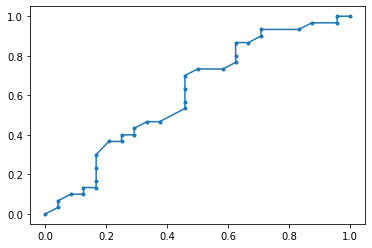

In [55]:
clf_fpr, clf_tpr, _ = health_results["classifier_scores"]["roc_curve"]
plt.plot(clf_fpr, clf_tpr, marker='.', label='Model')
# len(health_results["classifier_scores"]["roc_curve"])

In [ ]:
# get the education projects only
# extract further project features
# run through catboost, econml and the like

```qui regress mortality_under5 pc_commit_health lag_mortality_under5 ///
            lag_gdp_pc_ppp lag_fertility lag_population ///
            lag_physicians_rate  lag_female_adult_literacy ///
            lag_access_water lag_access_sanitation ///
            hiv_prevalence conflict i.period i.nregionname, r```

In [ ]:
# archiving original code for feature exploration:

# health_data = data[data.is_health_project]
# print("Health projects data: ", len(health_data), " versus all projects: ", len(data))

# target_col = 'mortality_under5_lag-5'

# hdata = health_data[['id'] + observed_X_cols + [target_col]]
# hdata = hdata.dropna()

# len(hdata)

# res_est = sm.OLS(endog=hdata[target_col], exog=sm.add_constant(hdata[observed_X_cols])).fit()

# print(res_est.summary2())

# hdata["mortality_under5_lag-5"].describe()

# target_resid = 'residual_mort_under5'

# residual = res_est.resid
# hdata[target_resid] = res_est.resid

# forest_data = hdata[['id', target_resid]].merge(data[['id'] + loan_features + cat_features], how='inner')
# forest_data = pd.get_dummies(forest_data, columns=loan_features + cat_features)
# len(forest_data)

# forest_data[f'{target_resid}_plus1std'] = forest_data[target_resid] > (
#     forest_data[target_resid].mean() + forest_data[target_resid].std()
# )

# forest_data[f'{target_resid}_plus1std'].value_counts()

# forest_data[target_resid].describe()

# X = forest_data.drop(columns=['id', target_resid, f'{target_resid}_plus1std'])
# y_reg = forest_data[target_resid]
# y_class = forest_data[f'{target_resid}_plus1std']

# fit_score_model(target_resid, nreg)

# bin_est, scores = fit_score_model(f'{target_resid}_plus1std', nest, classification=True)

# all_col_imp, summed_imp = extract_feature_imp(bin_est)

# summed_imp

# fin_type_agg = ['projectfinancialtype_IBRD', 'projectfinancialtype_IDA', 'projectfinancialtype_Other']
# { typ: sum_feature_imp(typ) for typ in fin_type_agg }

## Extract more complex features

## Build better models

## Extract SHAP and other values